## Ethereum Data Preparation


In [1]:
import numpy as np
import pandas as pd
import hvplot.pandas
from datetime import datetime, date
from functools import reduce
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
# Load the fear and greed sentiment data for Bitcoin (only fear and greed index)
fng_df = pd.read_csv('fng.csv')
fng_df = fng_df.rename(columns={'date':'Date', 'value_classification':'fng_class'})
fng_df = fng_df.drop(columns=['value'])
mapping = {'Extreme Fear':'-1.0', 'Fear':'-0.5', 'Neutral':'0.0', 
        'Greed':'0.5', 'Extreme Greed':'1.0'}
fng_df['fng_class'] = fng_df['fng_class'].map(mapping)
fng_df['fng_class'] = pd.to_numeric(fng_df['fng_class'])
fng_df['fng_class'] = fng_df['fng_class'].astype(float)
fng_df.set_index(['Date'], inplace=True)
fng_df.tail()

,fng_class
Date,
2019-02-01,-1.0
2019-01-31,-1.0
2019-01-30,-1.0
2019-01-29,-1.0
2019-01-28,-0.5


In [3]:
# Load the vader sentiment data for Ethereum
eth_vader_df = pd.read_csv('eth_vader.csv', infer_datetime_format=True, parse_dates=True)
eth_vader_df["Publish Date"] = [date[0:10] for date in eth_vader_df["Publish Date"]]
eth_vader_df = eth_vader_df.drop(columns=["Post ID", "Title", "Url", "Author", "Score", "Total No. of Comments", "Permalink",
        "title_pos", "title_neu", "title_neg", "title_sent"], axis=1)
eth_vader_df.rename(columns = {'Publish Date':'Date', 'title_compound': 'vader_compound'}, inplace = True)
eth_vader_df['vader_compound'] = eth_vader_df['vader_compound'].astype(float).round(decimals=2)
eth_vader_df.set_index(['Date'], inplace=True)
eth_vader_df.head()

,vader_compound
Date,
2019-01-24,0.20
2019-02-05,0.00
2019-02-06,-0.59
2019-02-13,0.00
2019-02-13,0.00


In [4]:
# Load the historical closing prices for Ethereum
eth_close_df = pd.read_csv('ethprices.csv')
eth_close_df = eth_close_df.sort_index()
eth_close_df = eth_close_df.rename(columns={'date':'Date', 'close':'close_price'})
eth_close_df = eth_close_df.drop(["symbol", "volume"], axis=1)
eth_close_df.set_index(['Date'], inplace=True)
eth_close_df.head()

,close_price
Date,
2019-01-28,105.43
2019-01-29,104.01
2019-01-30,107.50
2019-01-31,105.74
2019-02-01,105.69


In [5]:
# Load the exponential weighted moving average data for Ethereum
eth_ewm_df = pd.read_csv('eth_ema.csv')
eth_ewm_df = eth_ewm_df.sort_index()
eth_ewm_df = eth_ewm_df.rename(columns={'date':'Date', 'crossover_signal':'ewm_cross_signal'})
eth_ewm_df = eth_ewm_df.drop(["symbol", "close", "volume", "daily_return", "fast_close", "slow_close", "crossover_long", "crossover_short"], axis=1)
eth_ewm_df['ewm_cross_signal'] = eth_ewm_df['ewm_cross_signal'].astype(float)
eth_ewm_df.set_index(['Date'], inplace=True)
eth_ewm_df.head()

,ewm_cross_signal
Date,
2019-01-28,0.0
2019-01-29,-1.0
2019-01-30,1.0
2019-01-31,1.0
2019-02-01,1.0


In [6]:
# Load the money flow index for Ethereum
eth_mfi_df = pd.read_csv('mfi_eth.csv')
eth_mfi_df = eth_mfi_df.sort_index()
eth_mfi_df = eth_mfi_df.rename(columns={'date':'Date'})
eth_mfi_df = eth_mfi_df.drop(["symbol", "close", "volume", "Buy", "Sell"], axis=1)
eth_mfi_df['MFI'] = eth_mfi_df['MFI'].round(decimals=2)
eth_mfi_df["mfi_std"] = (eth_mfi_df['MFI'] - eth_mfi_df['MFI'].min())/(eth_mfi_df['MFI'].max() - eth_mfi_df['MFI'].min())
eth_mfi_df = eth_mfi_df.drop(columns=['MFI'])
eth_mfi_df.set_index(['Date'], inplace=True)
eth_mfi_df.head()

,mfi_std
Date,
2019-02-11,0.257686
2019-02-12,0.406931
2019-02-13,0.314561
2019-02-14,0.345444
2019-02-15,0.459055


In [7]:
# Load the money flow index for Ethereum
eth_google_df = pd.read_csv('eth_google.csv')
eth_google_df = eth_google_df.sort_index()
eth_google_df = eth_google_df.rename(columns={'Google Search Count':'google_search'})
eth_google_df['google_search'] = eth_google_df['google_search'].astype(float)
eth_google_df["google_std"] = (eth_google_df['google_search'] - eth_google_df['google_search'].min())/(eth_google_df['google_search'].max() - eth_google_df['google_search'].min())
eth_google_df = eth_google_df.drop(columns=['google_search'])
eth_google_df.set_index(['Date'], inplace=True)
round(eth_google_df,2)
eth_google_df.head()

,google_std
Date,
2019-01-28,0.020619
2019-01-29,0.020619
2019-01-30,0.020619
2019-01-31,0.020619
2019-02-01,0.020619


In [8]:
# MERGE the closing price, ewm, fng, mfi, and Google DataFrames into a single DataFrame
eth_dfs = [eth_close_df, eth_ewm_df, fng_df, eth_mfi_df, eth_google_df]
eth_data_df = reduce(lambda left, right: pd.merge(left, right, on='Date'), eth_dfs)
eth_df = eth_data_df.merge(eth_vader_df, on = 'Date', how = 'left')
eth_df.rename(columns = {'mfi_std':'mfi', 'google_std':'google_search'}, inplace = True)
eth_df['vader_compound'] = eth_df['vader_compound'].fillna(0)
round(eth_df,2)
eth_df.head()

,close_price,ewm_cross_signal,fng_class,mfi,google_search,vader_compound
Date,,,,,,
2019-02-11,119.52,1.0,-0.5,0.257686,0.041237,0.0
2019-02-12,121.18,1.0,-0.5,0.406931,0.041237,0.0
2019-02-13,120.58,1.0,0.0,0.314561,0.041237,0.0
2019-02-13,120.58,1.0,0.0,0.314561,0.041237,0.0
2019-02-14,119.37,1.0,0.0,0.345444,0.041237,0.0


In [9]:
# Load the gas price data for Ethereum
eth_gas_df = pd.read_csv('eth_gas_price.csv')
eth_gas_df = eth_gas_df.sort_index()
eth_gas_df["f0_"] = [date[0:10] for date in eth_gas_df["f0_"]]
eth_gas_df = eth_gas_df.rename(columns={'f0_':'Date'})
eth_gas_df["gas_std"] = (eth_gas_df['f1_'] - eth_gas_df['f1_'].min())/(eth_gas_df['f1_'].max() - eth_gas_df['f1_'].min())
eth_gas_df.set_index(['Date'], inplace=True)
eth_gas_df = eth_gas_df.drop(columns=['f1_'], axis=1)
eth_gas_df.head()

,gas_std
Date,
2020-05-31,0.027868
2019-11-04,0.009252
2019-07-19,0.014593
2019-09-02,0.011860
2019-05-24,0.013901


In [10]:
# Load the mining difficulty data for Ethereum
eth_diff_df = pd.read_csv('mining_diff.csv')
eth_diff_df = eth_diff_df.sort_index()
eth_diff_df["f0_"] = [date[0:10] for date in eth_diff_df["f0_"]]
eth_diff_df = eth_diff_df.rename(columns={'f0_':'Date'})
eth_diff_df = eth_diff_df.sort_index()
eth_diff_df['f1_'] = eth_diff_df['f1_'].astype(float)
eth_diff_df["diff_std"] = (eth_diff_df['f1_'] - eth_diff_df['f1_'].min())/(eth_diff_df['f1_'].max() - eth_diff_df['f1_'].min())
eth_diff_df.set_index(['Date'], inplace=True)
eth_diff_df = eth_diff_df.drop(columns=['f1_'], axis=1)
eth_diff_df.head()

,diff_std
Date,
2019-02-08,0.408881
2020-12-07,0.848444
2019-01-11,0.532525
2020-01-30,0.468691
2019-05-15,0.462793


In [11]:
# Load the actual ethereum value (transfers) data for Ethereum (volume of transactions by day)
eth_value_df = pd.read_csv('actual_eth_value.csv') #, index_col="date", infer_datetime_format=True, parse_dates=True)
eth_value_df = eth_value_df.sort_index()
eth_value_df["f0_"] = [date[0:10] for date in eth_value_df["f0_"]]
eth_value_df = eth_value_df.rename(columns={'f0_':'Date'})
eth_value_df['f1_'] = eth_value_df['f1_'].astype(float)
eth_value_df["transfers_std"] = (eth_value_df['f1_'] - eth_value_df['f1_'].min())/(eth_value_df['f1_'].max() - eth_value_df['f1_'].min())
eth_value_df.set_index(['Date'], inplace=True)
eth_value_df = eth_value_df.drop(columns=['f1_'], axis=1)
eth_value_df.head()

,transfers_std
Date,
2019-04-24,0.366645
2019-04-03,0.441157
2020-08-12,0.444444
2020-09-01,0.738111
2021-01-17,0.000000


In [12]:
# MERGE the mining data into a single DataFrame
dfs = [eth_diff_df, eth_gas_df, eth_value_df]
eth_mining_df = reduce(lambda left, right: pd.merge(left, right, on='Date'), dfs)
eth_string_time = "2019-02-08"
eth_datetime = datetime.strptime(eth_string_time, "%Y-%m-%d")
eth_mining_df.rename(columns = {'f0_':'Date', 'diff_std':'mining_difficulty', 'gas_std': 'gas_price', 'transfers_std':'total_transfers' }, inplace = True)
eth_mining_df.head()

,mining_difficulty,gas_price,total_transfers
Date,,,
2019-02-08,0.408881,0.004171,0.219812
2020-12-07,0.848444,0.069152,0.285558
2019-01-11,0.532525,0.005648,0.410476
2020-01-30,0.468691,0.002642,0.133246
2019-05-15,0.462793,0.014140,0.465264


In [13]:
# MERGE eth_mining_df with eth_df
eth_master_df = eth_df.merge(eth_mining_df, on = 'Date', how = 'left')
eth_master_df.head()

,close_price,ewm_cross_signal,fng_class,mfi,google_search,vader_compound,mining_difficulty,gas_price,total_transfers
Date,,,,,,,,,
2019-02-11,119.52,1.0,-0.5,0.257686,0.041237,0.0,0.410002,0.003789,0.193513
2019-02-12,121.18,1.0,-0.5,0.406931,0.041237,0.0,0.426929,0.003408,0.152970
2019-02-13,120.58,1.0,0.0,0.314561,0.041237,0.0,0.410910,0.004773,0.182555
2019-02-13,120.58,1.0,0.0,0.314561,0.041237,0.0,0.410910,0.004773,0.182555
2019-02-14,119.37,1.0,0.0,0.345444,0.041237,0.0,0.402840,0.007891,0.167215


---

## Random Forest Regressor for Multiple Features

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
#from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.datasets import load_boston
import shap
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Fitting and Predicting

In [15]:
# Define features set and target vector
dataset = eth_master_df
X = eth_master_df[['mining_difficulty', 'ewm_cross_signal','fng_class','mfi','google_search', 'vader_compound', 'gas_price', 'total_transfers']]
y = eth_master_df['close_price']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [17]:

#X_train, X_test= np.split(X, [int(.8 *len(X))])
#y_train, y_test= np.split(y, [int(.8 *len(y))])

In [18]:
# Create Random Forest Regressor and fit the model
rf_model = RandomForestRegressor(n_estimators=10, random_state=78)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=78)

In [19]:
# Make predictions using the testing data
predictions = rf_model.predict(X_test)

### Feature Importance

In [20]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.8874531247069282, 'mining_difficulty'),
 (0.059588031148244375, 'google_search'),
 (0.017131667466763655, 'gas_price'),
 (0.011757522740919278, 'mfi'),
 (0.01043702593201513, 'fng_class'),
 (0.00866853107245183, 'total_transfers'),
 (0.004703607861919376, 'ewm_cross_signal'),
 (0.0002604890707582284, 'vader_compound')]

In [21]:
#importances_df.head()

Text(0.5, 1.0, 'Features Importances')

<Figure size 432x288 with 0 Axes>

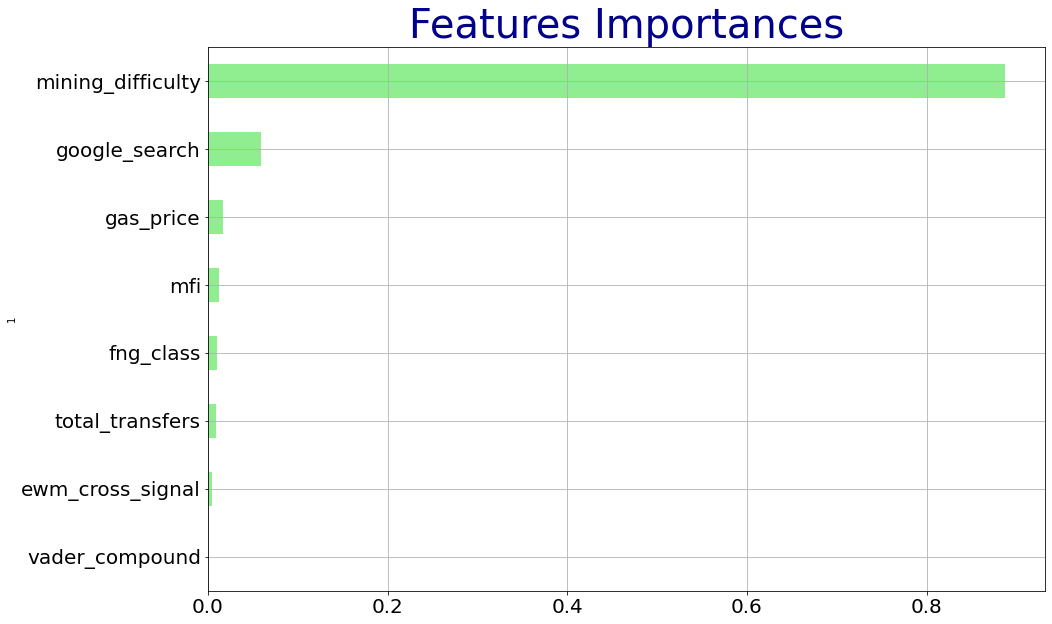

In [22]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
plt.savefig('features-importance.jpg')
importances_sorted.plot(kind='barh', color='lightgreen', figsize=(15,10), grid=True, 
                        fontsize=20, legend=False)
plt.title('Features Importances', fontsize=40, color='darkBlue')

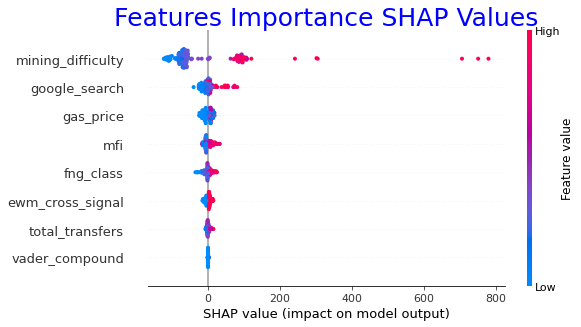

In [23]:
# Plot SHAP Values
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)
plt.savefig('features-importance-shap.jpg')
plt.title('Features Importance SHAP Values', fontsize=25, color='blue', pad=(5.0))
shap.summary_plot(shap_values, X_test)

### Model Evaluation

In [24]:
# r2_score (fit score) test
from sklearn.metrics import r2_score,mean_squared_error
r2_score(y_test, rf_model.predict(X_test))

0.9504792032320994

In [25]:
# FIX PERCENTAGE mean squared error
mse = mean_squared_error(y_test, rf_model.predict(X_test), squared=False)
mse

32.56499506269771

In [26]:
rmse = np.sqrt(mse)
rmse

5.706574722431812

In [27]:
eth_master_train_df, eth_master_test_df= np.split(eth_master_df, [int(.8 *len(eth_master_df))])
pred_df = pd.DataFrame(predictions, columns=['prediction_price'])
pred_df.index = eth_master_test_df.index
pred_df.head()

,prediction_price
Date,
2020-09-08,311.520
2020-09-09,426.191
2020-09-09,471.989
2020-09-09,169.702
2020-09-09,350.037


In [28]:
# # Plot ETH RF price comparison
# lstm_df.plot(figsize=(15,8), fontsize=15, grid=True, linewidth=3, rot=60)
# plt.savefig('lstm.jpg')
# plt.title('Ethereum Historical Real Price vs. Predicted Price', fontsize=25, 
#           fontweight=15, color='blue', pad=1.0)

In [29]:
#JOIN/MERGE/APPEND dataframes
eth_combined = eth_master_df.join(pred_df)
eth_combined.head()

,close_price,ewm_cross_signal,fng_class,mfi,google_search,vader_compound,mining_difficulty,gas_price,total_transfers,prediction_price
Date,,,,,,,,,,
2019-02-11,119.52,1.0,-0.5,0.257686,0.041237,0.0,0.410002,0.003789,0.193513,NaN
2019-02-12,121.18,1.0,-0.5,0.406931,0.041237,0.0,0.426929,0.003408,0.152970,NaN
2019-02-13,120.58,1.0,0.0,0.314561,0.041237,0.0,0.410910,0.004773,0.182555,NaN
2019-02-13,120.58,1.0,0.0,0.314561,0.041237,0.0,0.410910,0.004773,0.182555,NaN
2019-02-14,119.37,1.0,0.0,0.345444,0.041237,0.0,0.402840,0.007891,0.167215,NaN


In [30]:
# Create a DataFrame of Real and Predicted values
#eth_master_train_df, eth_master_test_df= np.split(eth_master_df, [int(.8 *len(eth_master_df))])
eth_pred_df = pd.DataFrame(eth_combined, columns=['prediction_price', 'close_price'])
eth_pred_df.head()


,prediction_price,close_price
Date,,
2019-02-11,NaN,119.52
2019-02-12,NaN,121.18
2019-02-13,NaN,120.58
2019-02-13,NaN,120.58
2019-02-14,NaN,119.37


Text(0.5, 1.0, 'Ethereum Historical Real Price vs. Random Forest Predicted Price')

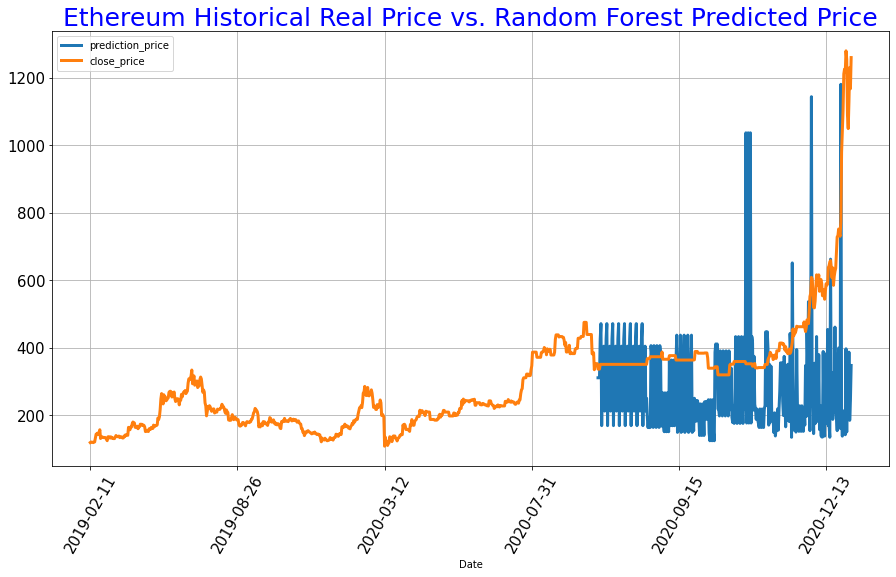

In [31]:
# Plot price comparison
eth_pred_df.plot(figsize=(15,8), fontsize=15, grid=True, linewidth=3, rot=60)
plt.savefig('eth_pred_rf.jpg')
plt.title('Ethereum Historical Real Price vs. Random Forest Predicted Price', fontsize=25, 
          fontweight=15, color='blue', pad=1.0)

In [32]:
eth_master_pct_change = eth_combined.pct_change()
eth_master_pct_change_corr = eth_master_pct_change.corr()
eth_master_pct_change_corr

,close_price,ewm_cross_signal,fng_class,mfi,google_search,vader_compound,mining_difficulty,gas_price,total_transfers,prediction_price
close_price,1.000000,-0.009676,-0.030690,0.154861,0.010399,0.017799,-0.017812,-0.061878,-0.023511,0.038544
ewm_cross_signal,-0.009676,1.000000,0.019358,0.003989,0.017387,0.134632,0.037271,-0.005860,-0.124258,0.038139
fng_class,-0.030690,0.019358,1.000000,0.011812,0.006420,-0.006907,0.001555,-0.014570,-0.041435,0.094673
mfi,0.154861,0.003989,0.011812,1.000000,-0.008137,-0.048805,0.020776,-0.024185,-0.033305,0.011515
google_search,0.010399,0.017387,0.006420,-0.008137,1.000000,-0.001771,-0.026218,-0.059195,0.045310,-0.044362
vader_compound,0.017799,0.134632,-0.006907,-0.048805,-0.001771,1.000000,0.007139,-0.030170,-0.094740,-0.011915
mining_difficulty,-0.017812,0.037271,0.001555,0.020776,-0.026218,0.007139,1.000000,0.051425,-0.046021,-0.016524
gas_price,-0.061878,-0.005860,-0.014570,-0.024185,-0.059195,-0.030170,0.051425,1.000000,0.187840,0.064651
total_transfers,-0.023511,-0.124258,-0.041435,-0.033305,0.045310,-0.094740,-0.046021,0.187840,1.000000,0.003041
prediction_price,0.038544,0.038139,0.094673,0.011515,-0.044362,-0.011915,-0.016524,0.064651,0.003041,1.000000


Text(0.5, 1.0, 'Heatmap of LSTM Model Features (ETH)')

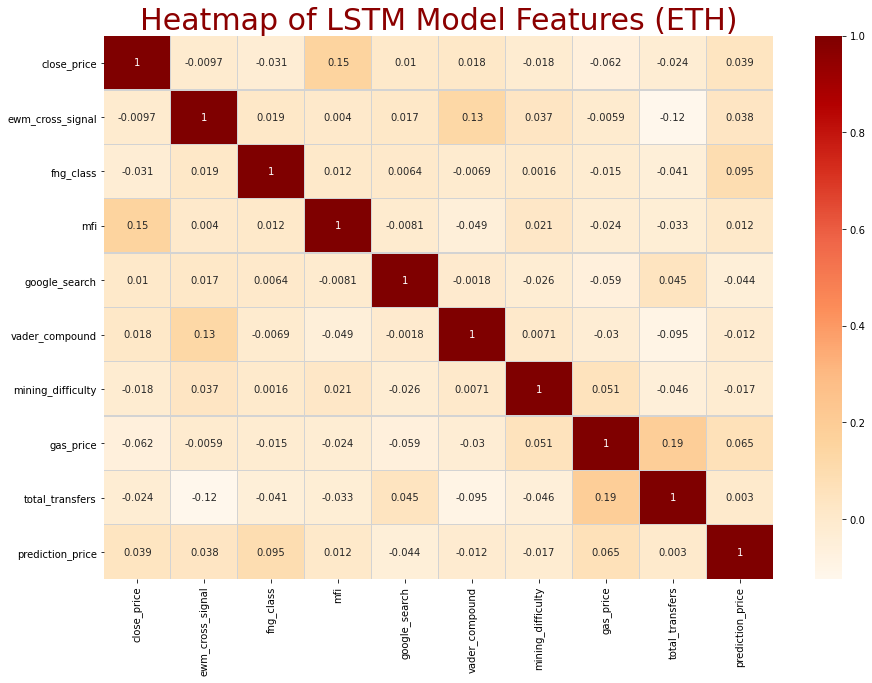

In [33]:
# Plot features importances heatmap
plt.figure(figsize = (15,10))
sns.heatmap(eth_master_pct_change_corr,cmap='OrRd', annot=True, linecolor='lightgray', linewidths=.3)
plt.savefig("rf_heatmap.jpg")
plt.title('Heatmap of LSTM Model Features (ETH)', color='darkred', pad=3.0, fontsize = 30)

---

### RF Analysis for Win/Lose Call Accuracy

In [34]:
#Add column for "actual_day_positive_move" positive move = true & negative move = false
eth_combined["actual_day_positive_move"] = eth_combined["close_price"]-eth_combined["close_price"].shift(1)>0
eth_combined.tail()

,close_price,ewm_cross_signal,fng_class,mfi,google_search,vader_compound,mining_difficulty,gas_price,total_transfers,prediction_price,actual_day_positive_move
Date,,,,,,,,,,,
2021-01-12,1049.98,1.0,1.0,0.519285,0.690722,0.0,0.976442,0.130492,0.389656,243.344,False
2021-01-13,1129.90,1.0,1.0,0.539827,0.690722,0.0,0.979995,0.097449,0.412667,387.570,True
2021-01-14,1231.08,1.0,1.0,0.591392,0.690722,0.0,0.982190,0.130189,0.714004,185.393,True
2021-01-15,1168.24,1.0,1.0,0.552963,0.690722,0.0,0.983228,0.149419,0.396231,243.400,False
2021-01-16,1260.48,1.0,1.0,0.583706,0.690722,0.0,1.000000,0.124411,0.300899,347.998,True


In [35]:
#Add column for "predicted day positive move" positive move = true & negative move = false
eth_combined["predicted_day_positive_move"] = eth_combined["prediction_price"]-eth_combined["prediction_price"].shift(1)>0
eth_combined.tail()

,close_price,ewm_cross_signal,fng_class,mfi,google_search,vader_compound,mining_difficulty,gas_price,total_transfers,prediction_price,actual_day_positive_move,predicted_day_positive_move
Date,,,,,,,,,,,,
2021-01-12,1049.98,1.0,1.0,0.519285,0.690722,0.0,0.976442,0.130492,0.389656,243.344,False,False
2021-01-13,1129.90,1.0,1.0,0.539827,0.690722,0.0,0.979995,0.097449,0.412667,387.570,True,True
2021-01-14,1231.08,1.0,1.0,0.591392,0.690722,0.0,0.982190,0.130189,0.714004,185.393,True,False
2021-01-15,1168.24,1.0,1.0,0.552963,0.690722,0.0,0.983228,0.149419,0.396231,243.400,False,True
2021-01-16,1260.48,1.0,1.0,0.583706,0.690722,0.0,1.000000,0.124411,0.300899,347.998,True,True


In [36]:
# Add "correct call" column if both had true or both had false we have a true 
eth_combined["Correct Call Count"] = np.where(eth_combined["actual_day_positive_move"]==eth_combined["predicted_day_positive_move"], True, False)
eth_combined.head()

,close_price,ewm_cross_signal,fng_class,mfi,google_search,vader_compound,mining_difficulty,gas_price,total_transfers,prediction_price,actual_day_positive_move,predicted_day_positive_move,Correct Call Count
Date,,,,,,,,,,,,,
2019-02-11,119.52,1.0,-0.5,0.257686,0.041237,0.0,0.410002,0.003789,0.193513,NaN,False,False,True
2019-02-12,121.18,1.0,-0.5,0.406931,0.041237,0.0,0.426929,0.003408,0.152970,NaN,True,False,False
2019-02-13,120.58,1.0,0.0,0.314561,0.041237,0.0,0.410910,0.004773,0.182555,NaN,False,False,True
2019-02-13,120.58,1.0,0.0,0.314561,0.041237,0.0,0.410910,0.004773,0.182555,NaN,False,False,True
2019-02-14,119.37,1.0,0.0,0.345444,0.041237,0.0,0.402840,0.007891,0.167215,NaN,False,False,True


In [37]:
#Remove rows w/o predicted prices
rf_eth_calls = eth_combined.iloc[872:]
rf_eth_calls.head()

,close_price,ewm_cross_signal,fng_class,mfi,google_search,vader_compound,mining_difficulty,gas_price,total_transfers,prediction_price,actual_day_positive_move,predicted_day_positive_move,Correct Call Count
Date,,,,,,,,,,,,,
2020-09-27,351.90,-1.0,0.0,0.640162,0.030928,0.0,0.751274,0.106224,0.270217,194.904,False,False,True
2020-09-28,351.90,-1.0,-0.5,0.584684,0.030928,0.0,0.748886,0.170731,0.345825,178.910,False,False,True
2020-09-29,351.90,-1.0,-0.5,0.687255,0.030928,0.0,0.747971,0.218155,0.390752,227.080,False,True,False
2020-09-30,359.69,-1.0,0.0,0.634852,0.030928,0.0,0.754082,0.167510,0.396231,176.271,True,False,False
2020-09-30,359.69,-1.0,0.0,0.634852,0.030928,0.0,0.754082,0.167510,0.396231,239.806,False,True,False


In [38]:
# convert to pivot table
rf_eth_calls = rf_eth_calls.pivot_table(index=['Correct Call Count'], aggfunc='size')
rf_eth_calls

Correct Call Count
False    78
True     85
dtype: int64

In [39]:
# calculate lose rate
rf_eth_calls['lose_rate'] = (rf_eth_calls.iloc[0] / (163))*100
rf_eth_calls

Correct Call Count
False        78.000000
True         85.000000
lose_rate    47.852761
dtype: float64

In [40]:
# calculate win rate
rf_eth_calls['win_rate'] = (rf_eth_calls.iloc[1] / (163))*100
rf_eth_calls

Correct Call Count
False        78.000000
True         85.000000
lose_rate    47.852761
win_rate     52.147239
dtype: float64

---

## Features Decision Tree

In [41]:
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_iris
from sklearn import tree
import pydotplus
from IPython.display import Image

In [42]:
# Prepare the data
dataset = eth_combined
X = eth_combined[['close_price','ewm_cross_signal','fng_class','mfi','google_search', 'vader_compound', 'mining_difficulty', 'gas_price', 'total_transfers']]
y = eth_combined["close_price"]

In [43]:
# Fit the regressor, set max_depth = 3
regr = DecisionTreeRegressor(max_depth=3, min_samples_leaf=25, random_state=78)
model = regr.fit(X, y)

Text(0.5, 1.0, 'Features Decision Tree')

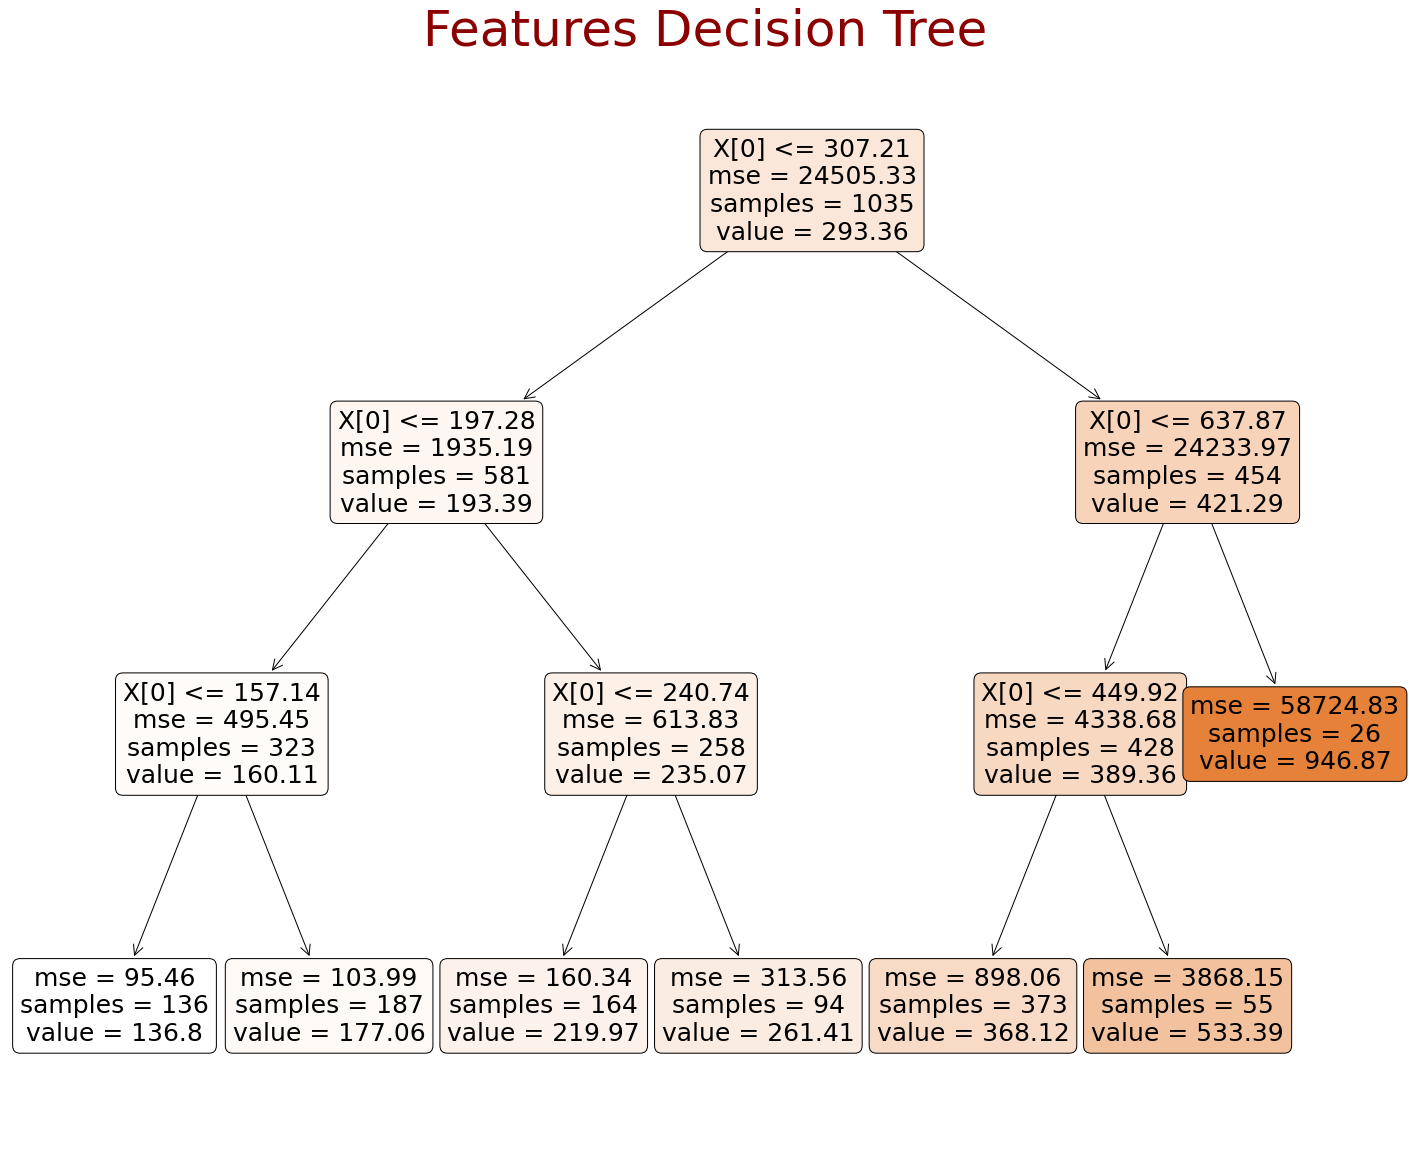

In [44]:
fig = plt.figure(figsize=(25,20))
plt.savefig('decision-tree.jpg')
fig = tree.plot_tree(regr, filled=True, rounded=True, precision=2, fontsize=25)
plt.title('Features Decision Tree', fontsize=50, color='darkred')

In [45]:
eth_combined = eth_master_df.join(pred_df)
np.round(eth_combined,2)
eth_combined.head()

,close_price,ewm_cross_signal,fng_class,mfi,google_search,vader_compound,mining_difficulty,gas_price,total_transfers,prediction_price
Date,,,,,,,,,,
2019-02-11,119.52,1.0,-0.5,0.257686,0.041237,0.0,0.410002,0.003789,0.193513,NaN
2019-02-12,121.18,1.0,-0.5,0.406931,0.041237,0.0,0.426929,0.003408,0.152970,NaN
2019-02-13,120.58,1.0,0.0,0.314561,0.041237,0.0,0.410910,0.004773,0.182555,NaN
2019-02-13,120.58,1.0,0.0,0.314561,0.041237,0.0,0.410910,0.004773,0.182555,NaN
2019-02-14,119.37,1.0,0.0,0.345444,0.041237,0.0,0.402840,0.007891,0.167215,NaN


----

## LSTM Recurrent Neural Network for Historical and Predicted Closing Prices

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from numpy.random import seed
from tensorflow import random
from sklearn.preprocessing import MinMaxScaler

In [47]:
# Set the random seed for reproducibility
seed(1)
random.set_seed(2)

In [48]:
# Create function for features (X) and targeet(y)
def window_data(eth_combined, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(eth_combined) - window - 1):
        features = eth_combined.iloc[i:(i + window), feature_col_number]
        target = eth_combined.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [49]:
# Predict Closing Prices 
window_size = 10

# Column 0 is `Close Price`
feature_column = 0
target_column = 0
X, y = window_data(eth_combined, window_size, feature_column, target_column)

In [50]:
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test_scaler = y[split:]

In [51]:
# Use the MinMaxScaler to scale data between 0 and 1.
scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test_scaler = scaler.transform(y_test_scaler)


In [52]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

---

### Build and Train the Model

In [53]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,             #carries the values forward
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))


In [54]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [55]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 30)            3840      
_________________________________________________________________
dropout (Dropout)            (None, 10, 30)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 30)            7320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

In [56]:
# Train the model
model.fit(X_train, y_train, epochs=50, shuffle=False, batch_size=100, verbose=0)

---

### Model Performance

In [57]:
# Evaluate the model
model.evaluate(X_test, y_test_scaler)

10/10 [==============================] - 1s 3ms/step - loss: 0.0040


0.004000884015113115

In [58]:
# Make some predictions
predicted = model.predict(X_test)

In [59]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
#np.round(predicted_prices, 2)
real_prices = scaler.inverse_transform(y_test_scaler.reshape(-1, 1))

In [60]:
# Create a DataFrame of Real and Predicted values
lstm_df = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = eth_combined.index[-len(real_prices): ]) 
np.around(lstm_df, 2)
lstm_df.head()

,Real,Predicted
Date,,
2020-09-09,351.29,345.492035
2020-09-09,351.29,345.492035
2020-09-09,351.29,345.492035
2020-09-09,351.29,345.492035
2020-09-09,351.29,345.492035


Text(0.5, 1.0, 'Ethereum Historical Real Price vs. Predicted Price')

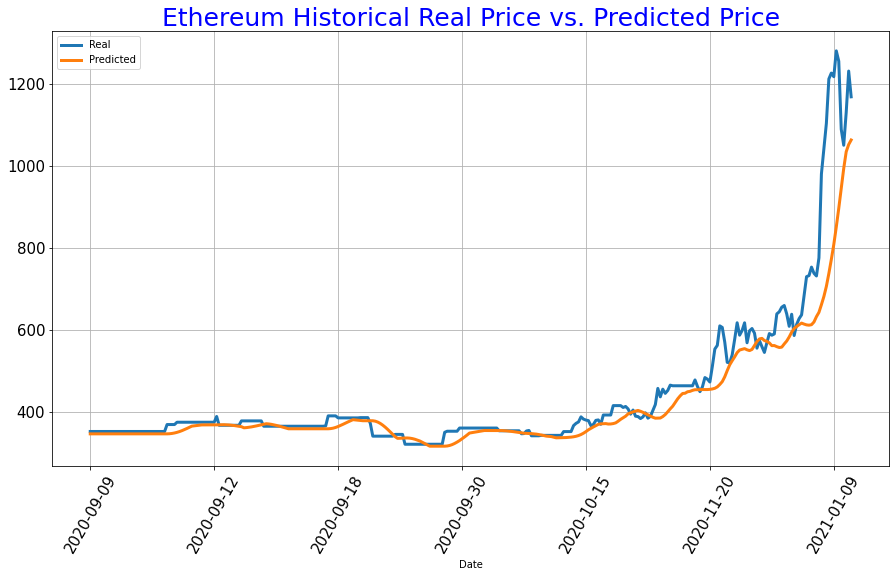

In [61]:
# Plot price comparison
lstm_df.plot(figsize=(15,8), fontsize=15, grid=True, linewidth=3, rot=60)
plt.savefig('lstm.jpg')
plt.title('Ethereum Historical Real Price vs. Predicted Price', fontsize=25, 
          fontweight=15, color='blue', pad=1.0)


In [62]:
lstm_df["actual_day_positive_move"] = lstm_df["Real"]-lstm_df["Real"].shift(1)>0
lstm_df.tail()

,Real,Predicted,actual_day_positive_move
Date,,,
2021-01-12,1088.94,945.199524,False
2021-01-13,1049.98,993.330200,False
2021-01-14,1129.90,1034.124023,True
2021-01-15,1231.08,1051.731445,True
2021-01-16,1168.24,1062.814453,False


In [63]:
lstm_df["predicted_day_positive_move"] = lstm_df["Predicted"]-lstm_df["Predicted"].shift(1)>0
lstm_df.tail()

,Real,Predicted,actual_day_positive_move,predicted_day_positive_move
Date,,,,
2021-01-12,1088.94,945.199524,False,True
2021-01-13,1049.98,993.330200,False,True
2021-01-14,1129.90,1034.124023,True,True
2021-01-15,1231.08,1051.731445,True,True
2021-01-16,1168.24,1062.814453,False,True


In [64]:
lstm_df["Call Accuracy Count"] = np.where(lstm_df["actual_day_positive_move"]==lstm_df["predicted_day_positive_move"], True, False)
round(lstm_df,2)
lstm_df.tail()

,Real,Predicted,actual_day_positive_move,predicted_day_positive_move,Call Accuracy Count
Date,,,,,
2021-01-12,1088.94,945.199524,False,True,False
2021-01-13,1049.98,993.330200,False,True,False
2021-01-14,1129.90,1034.124023,True,True,True
2021-01-15,1231.08,1051.731445,True,True,True
2021-01-16,1168.24,1062.814453,False,True,False


In [65]:
lstm_df = lstm_df.pivot_table(index=['Call Accuracy Count'], aggfunc='size')
lstm_df_pivot = lstm_df
lstm_df_pivot

Call Accuracy Count
False    134
True     174
dtype: int64

In [66]:
# calculate lose rate
lstm_df_pivot['lose_rate'] = (lstm_df_pivot.iloc[0] / (308))*100
round(lstm_df_pivot,2)
#stock_pivot['win_rate'] = (stock_pivot.iloc[1] / (308))*100
#print("f: The lstm_df win rate is "{stock_pivot}".")

Call Accuracy Count
False        134.00
True         174.00
lose_rate     43.51
dtype: float64

In [67]:
# calculate win rate
lstm_df_pivot['win_rate'] = (lstm_df_pivot.iloc[1] / (308))*100
round(lstm_df_pivot,2)

Call Accuracy Count
False        134.00
True         174.00
lose_rate     43.51
win_rate      56.49
dtype: float64

---

## Which Model Had the Best Call Accuracy Rate?

In [68]:
combined_pivot = pd.concat([rf_eth_calls, lstm_df_pivot], axis=1, keys=['Random Forest Calls', 'LSTM RNN Calls'], join='inner')
combined_pivot

,Random Forest Calls,LSTM RNN Calls
False,78.000000,134.000000
True,85.000000,174.000000
lose_rate,47.852761,43.506494
win_rate,52.147239,56.493506


Text(0.5, 1.0, 'Win/Lose Call Accuracy by Model')

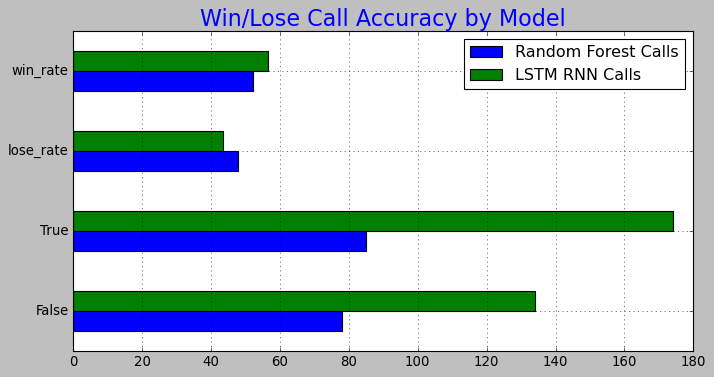

In [69]:
# Plot call accuracy by model
plt.style.use('classic')
combined_pivot = combined_pivot.plot(kind='barh', figsize=(10,5), fontsize=12, grid=True)
plt.savefig('win-lose-compare.jpg')
plt.title('Win/Lose Call Accuracy by Model', fontsize=20, fontweight=15, color='blue', pad=1.0)

---

## Dashboarding

In [70]:
from panel.interact import interact
import plotly.express as px
import panel as pn
pn.extension('plotly')
import matplotlib.pyplot as plt
import matplotlib.image as img 

In [71]:
def eth_historical_plot():
    lstm_df = pd.DataFrame({
        "Real": real_prices.ravel(),
        "Predicted": predicted_prices.ravel()
    }, index = eth_combined.index[-len(real_prices): ]) 
    fig_eth_historical = plt.figure()
    plot_lstm_df = lstm_df.plot(figsize=(15,8), fontsize=15, grid=True, linewidth=3, rot=60)
  #  plot_lstm_df.title('Ethereum Historical Real Price vs. Predicted Price', fontsize=25, fontweight=15) # , color='blue'
    plt.close(fig_eth_historical)
    return pn.pane.Matplotlib(fig_eth_historical)

def features_plot():
    importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X), reverse=True))
    importances_df.set_index(importances_df[1], inplace=True)
    importances_df.drop(columns=1, inplace=True)
    importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
    importances_sorted = importances_df.sort_values(by='Feature Importances')
    fig_features = plt.figure()
    plot_features = importances_sorted.plot(kind='barh', color='lightgreen', figsize=(15,10), grid=True, 
        fontsize=20, legend=True)
    plt.close(fig_features)
    return plt (fig_features)

def heatmap_plot():
    eth_master_pct_change = eth_combined.pct_change()
    eth_master_pct_change_corr = eth_master_pct_change.corr()
    fig_heatmap = plt.figure()
    sns.heatmap(eth_master_pct_change_corr,cmap='OrRd', annot=True, linecolor='lightgray', linewidths=.3)
    plt.title('Heatmap of LSTM Model Features (ETH)', color='darkred', pad=3.0, fontsize = 30)
    plt.close(fig_heatmap)
    return plt

# def features_image():
#     im = img.imread('features-importance.png')
#     plt.imshow(im) 
#     return im

TypeError: 'module' object is not callable

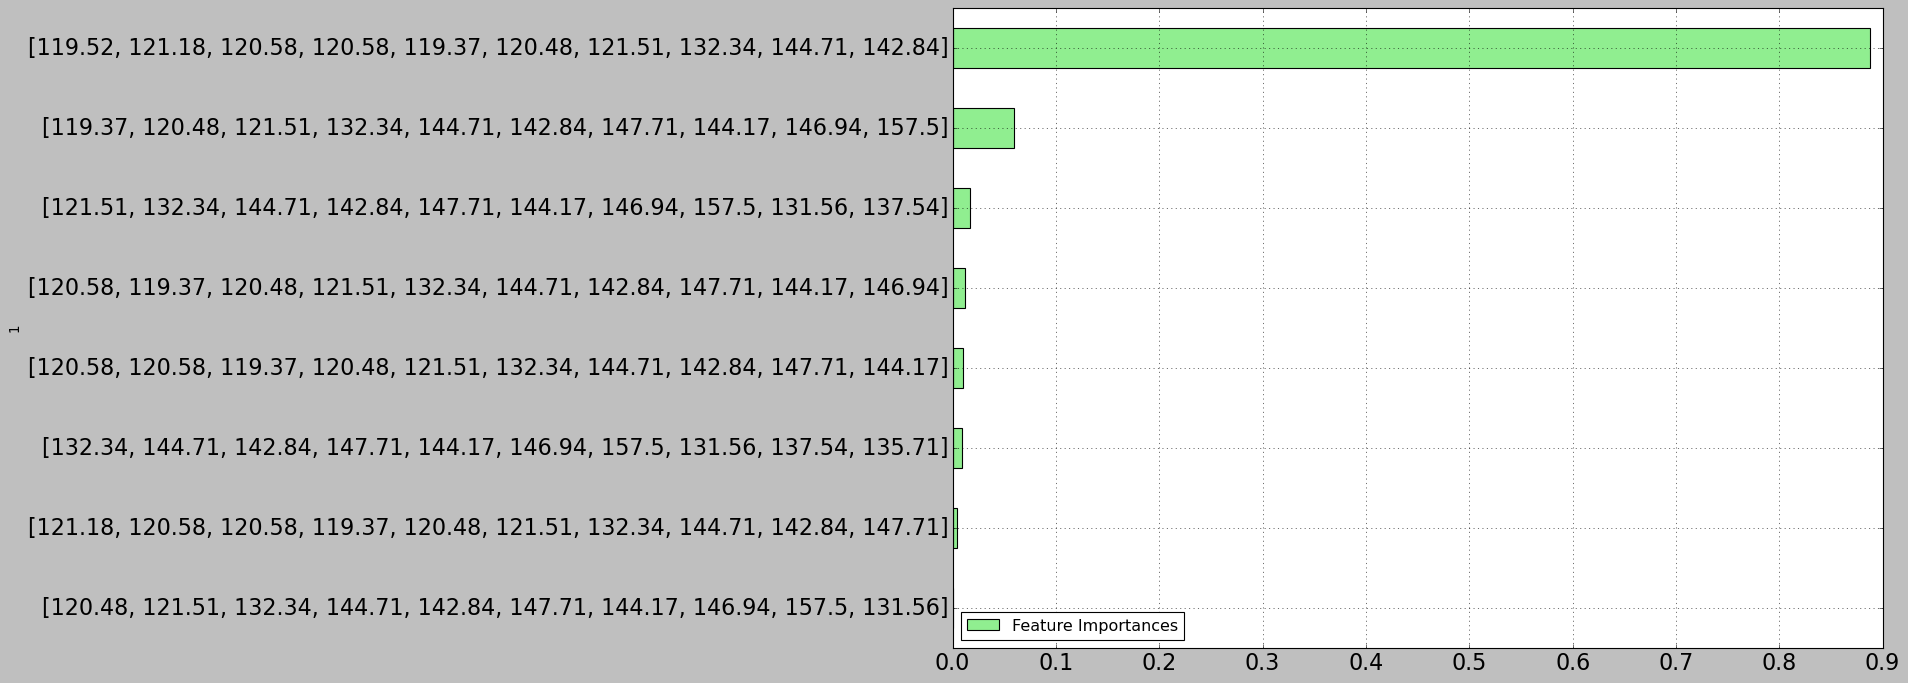

In [72]:
features_plot()

In [ ]:
#portfolio_list_select = pn.widgets.MultiSelect(name='Portfolio', options=['bitcoin', 'ethereum', 'chainlink', 'polkadot', 'tellor'])
#row_1 = pn.Row(
    #eth_historical_plot())
#row_2 = pn.Row(
 #   features_plot(importances_sorted))
    
title1 = pn.pane.Markdown('#Indicators or Historical Price? ', style={'font-family': "serif", "font-color":"navy"})
title2 = pn.pane.Markdown('#Historical Results', style={'font-family': "serif", "font-color":"navy"})
title3 = pn.pane.Markdown('#Correlation and Features Importance', style={'font-family': "serif", "font-color":"navy"})
title4 = pn.pane.Markdown('#Win/Lose Call Accuracy', style={'font-family': "serif", "font-color":"navy"})

overview_column = pn.Column(title1,
    '**PROJECT BACKGROUND** - '
    'Can technical indicators be fit to a Machine Learning model '
    'and become reliable predictors of cryptocurrency prices?',
    'Are historical prices the best indicators of predicted prices? '
    'The goal of this project is to determine if either of two models can be used '
    'to accurately predict a next-day price of four cryptocurrencies: '
    'A **Random Forest Regressor** model for technical indicators as features analysis '
    'and an **LSTM Recurrent Neural Network** model for the historical price analysis. ',
    
    '###**Sentiment and Historical Features**',
    eth_df.head(), 
    '###**On-Chain Features**',
    eth_mining_df.head(),
    background='#E0DFE5', width=700, height=600, scroll=True)

historical_column = pn.Column(title2,
    'How did predicted Ethereum prices model against two-year historical prices?',
    eth_historical_plot()
)

features_column = pn.Column(title3,
    'How did the technical indicators model against historical Ethereum prices?',
#     features_plot(), heatmap_plot()
   features_image()
)


                            
eth_dashboard = pn.Tabs(
    ("Overview", overview_column),
    ("LSTM RNN", historical_column),
    ("Random Forest Regressor", features_column), #features_column), # shap_plot),
    #("Conclusion", conclusion_column),
    dynamic=True, tabs_location="above", background="#E5E4EB"
)

eth_dashboard.servable()